In [82]:
import geopandas
import pandas as pd
import numpy as np

In [83]:
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

# data cleaning/formatting

In [84]:
df = pd.read_feather('dataset.v1.4.feather')
df['cases'] = df['cases'].fillna(0)
df['deaths'] = df['deaths'].fillna(0)

In [85]:
# remove anomalies
df = df[(np.abs(stats.zscore(df['cases'])) < 3)]

In [86]:
df['cases'].describe()

count    2.097000e+03
mean     1.056236e+04
std      9.192121e+04
min      0.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      1.870000e+02
max      2.000000e+06
Name: cases, dtype: float64

In [87]:
df['disease'] = df['disease'].astype('category')

In [88]:
df['issue_date'] = pd.to_datetime(df['issue_date'])

In [89]:
df['issue_month'] = df['issue_date'].dt.month

In [90]:
df = df[df['zoom_lat'].notna()]

In [91]:
df.keys()

Index(['level_0', 'index', 'id', 'title', 'zoom_lat', 'zoom_lon', 'zoom_level',
       'alert_id', 'feed_id', 'summary', 'issue_date', 'load_date',
       'incident_date', 'descr', 'alert_tag_id', 'dup_count', 'dup_of',
       'unique_string', 'info_hash', 'submitted_by', 'reviewed',
       'search_string_id', 'content', 'disease', 'gpm_lat_idx', 'gpm_lon_idx',
       'precipitation_anomaly', 'location_name', 'dates_start', 'serotype',
       'total_cases', 'cases', 'severe_cases', 'deaths', 'admin1_code',
       'admin2_code', 'admin3_code', 'admin4_code', 'cases_tags',
       'deaths_tags', 'dates_end', 'precipitation_value', 'precipitation_mean',
       'issue_month'],
      dtype='object')

# EDA

In [92]:
plot_df = df[df['cases'] <= 10000]

In [93]:
def plot_cases(disease=None):
	if not disease:
		gdf = geopandas.GeoDataFrame(plot_df, geometry=geopandas.points_from_xy(plot_df['zoom_lon'], plot_df['zoom_lat']))
	else:
		gdf = geopandas.GeoDataFrame(plot_df[plot_df['disease'] == disease], geometry=geopandas.points_from_xy(plot_df.loc[plot_df['disease'] == disease, 'zoom_lon'], plot_df.loc[plot_df['disease'] == disease, 'zoom_lat']))
	world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

	# We exclude antarctica
	ax = world[world.name!="Antarctica"].plot(alpha=0.4, edgecolor='black', figsize=(100, 75))
	gdf.plot(ax=ax, color='red', markersize='cases')

	plt.show()

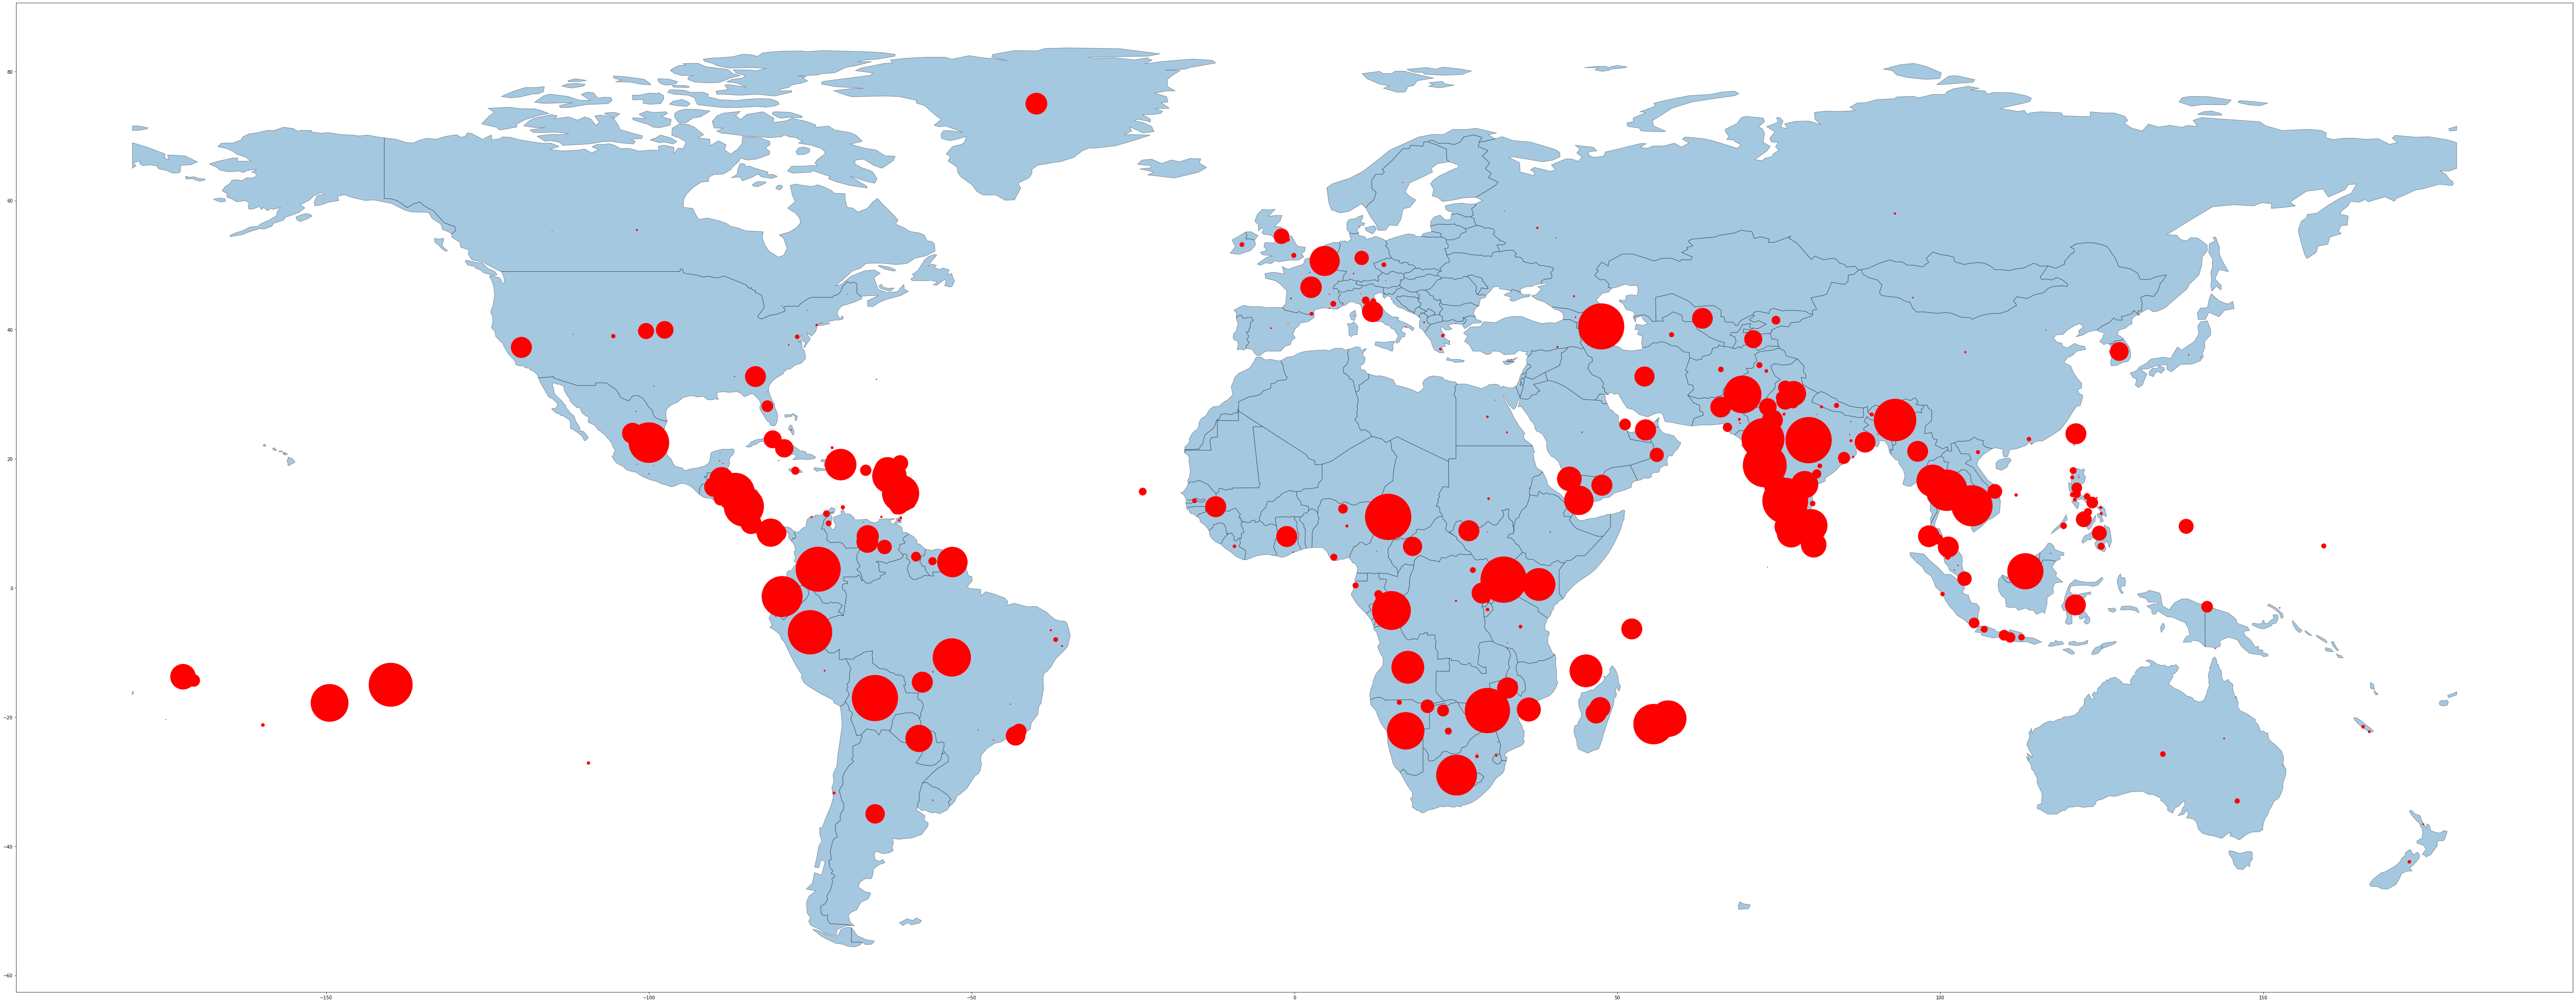

In [94]:
plot_cases()

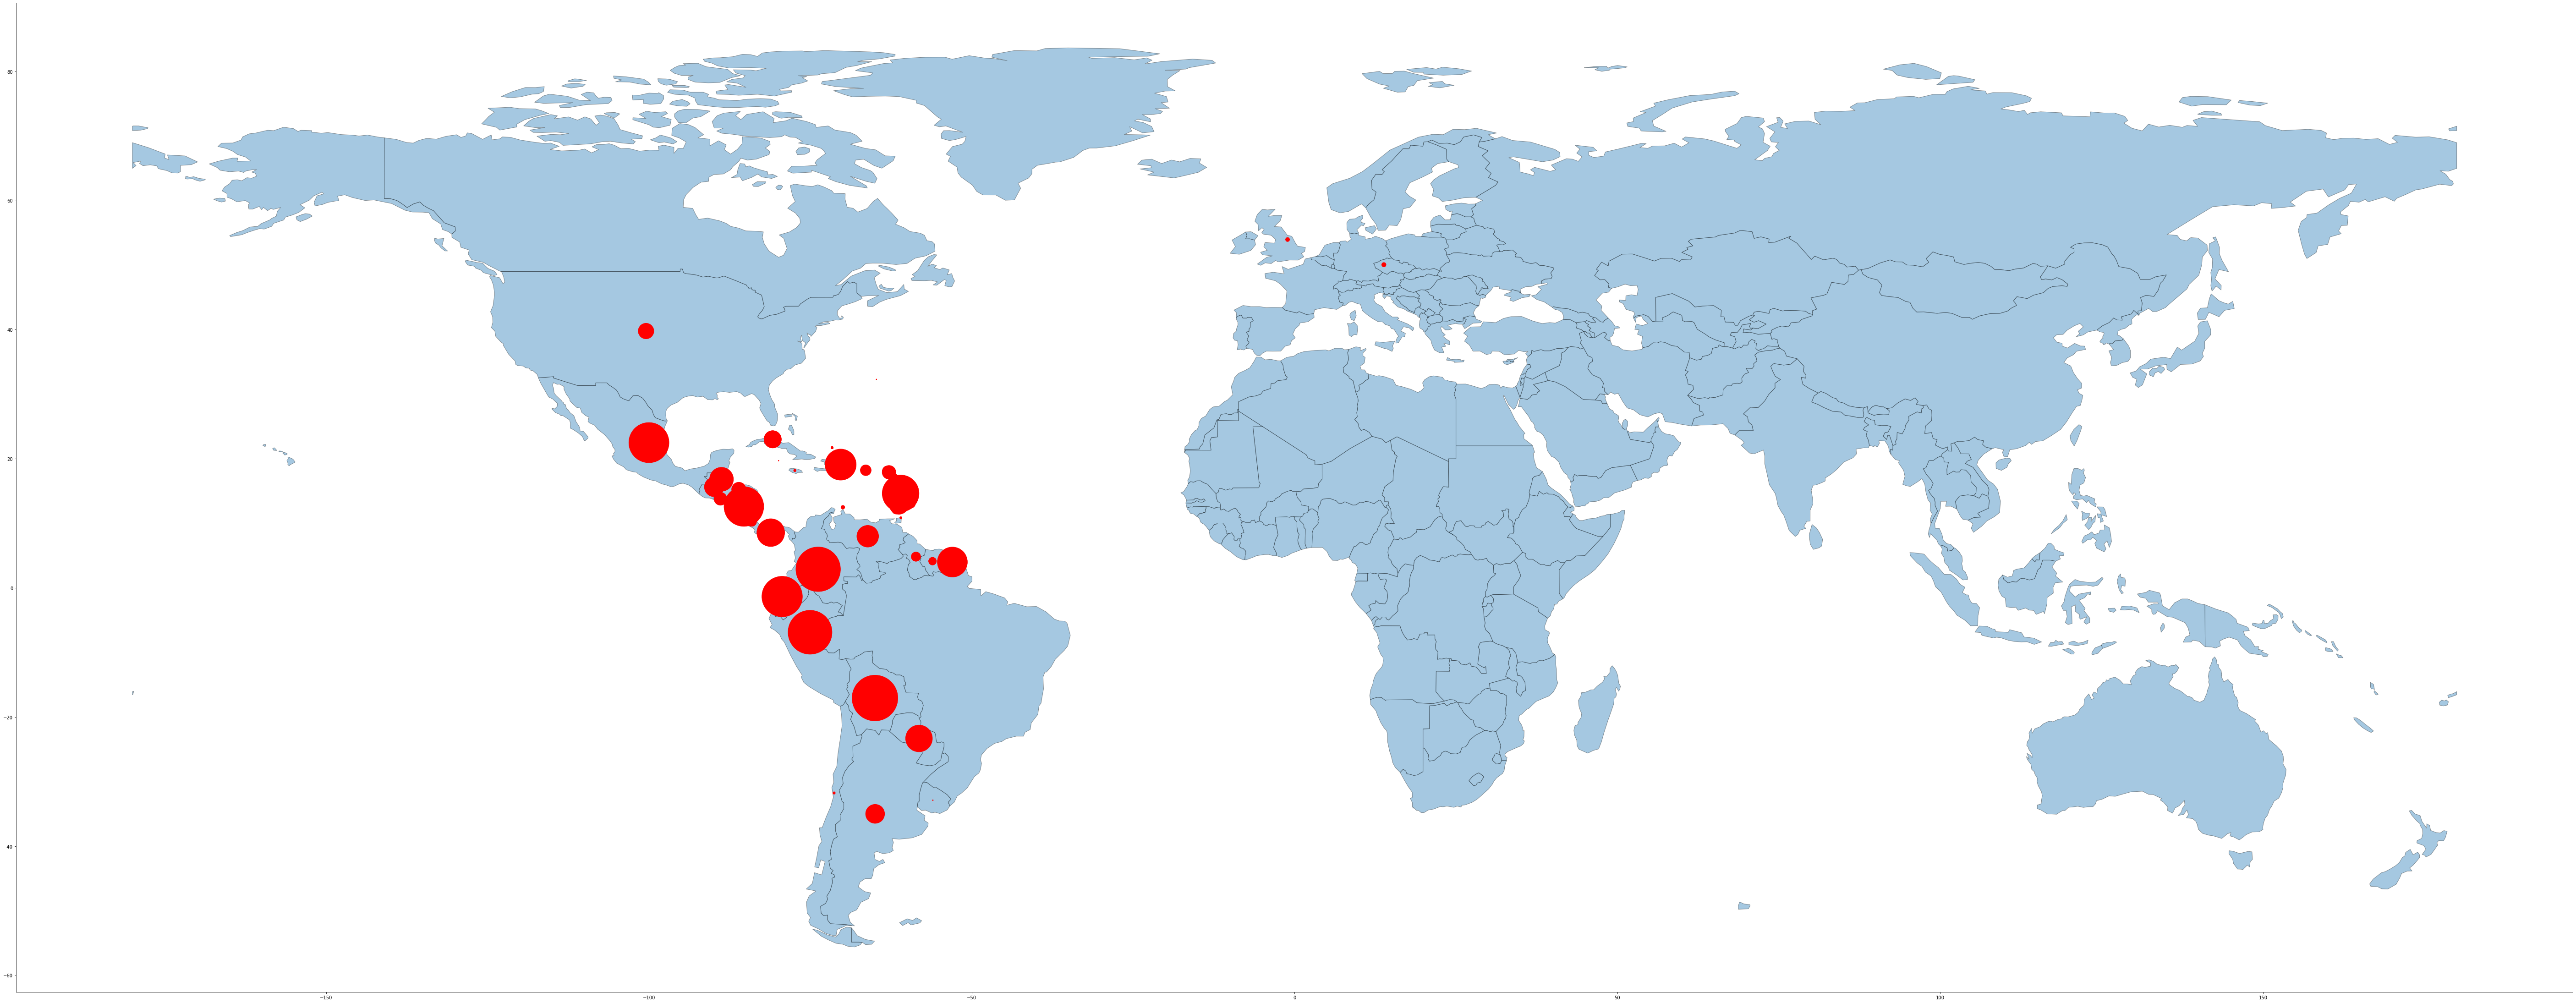

In [95]:
plot_cases('dengue')

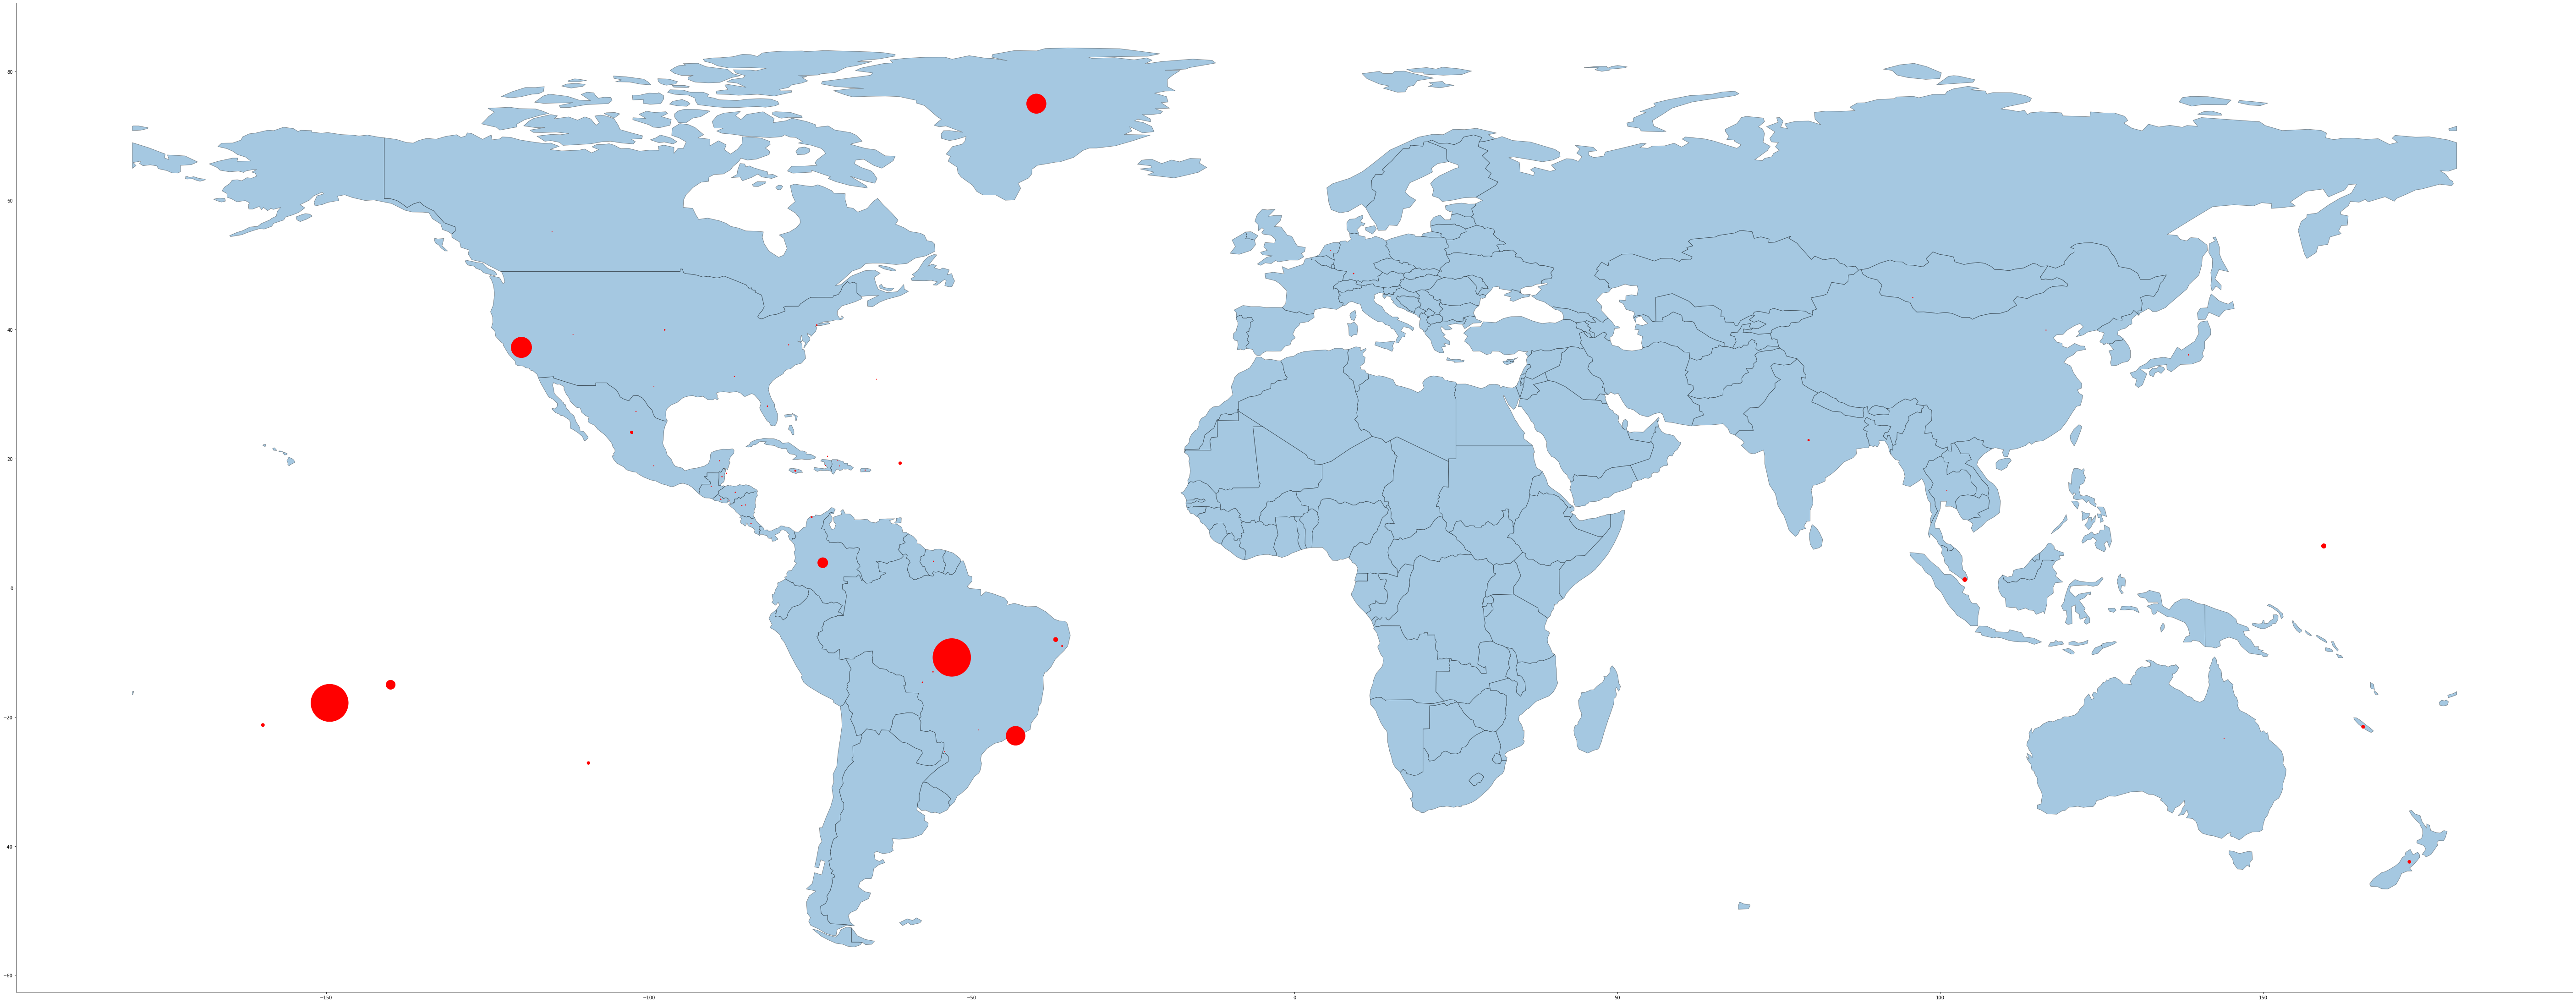

In [96]:
plot_cases('zika')

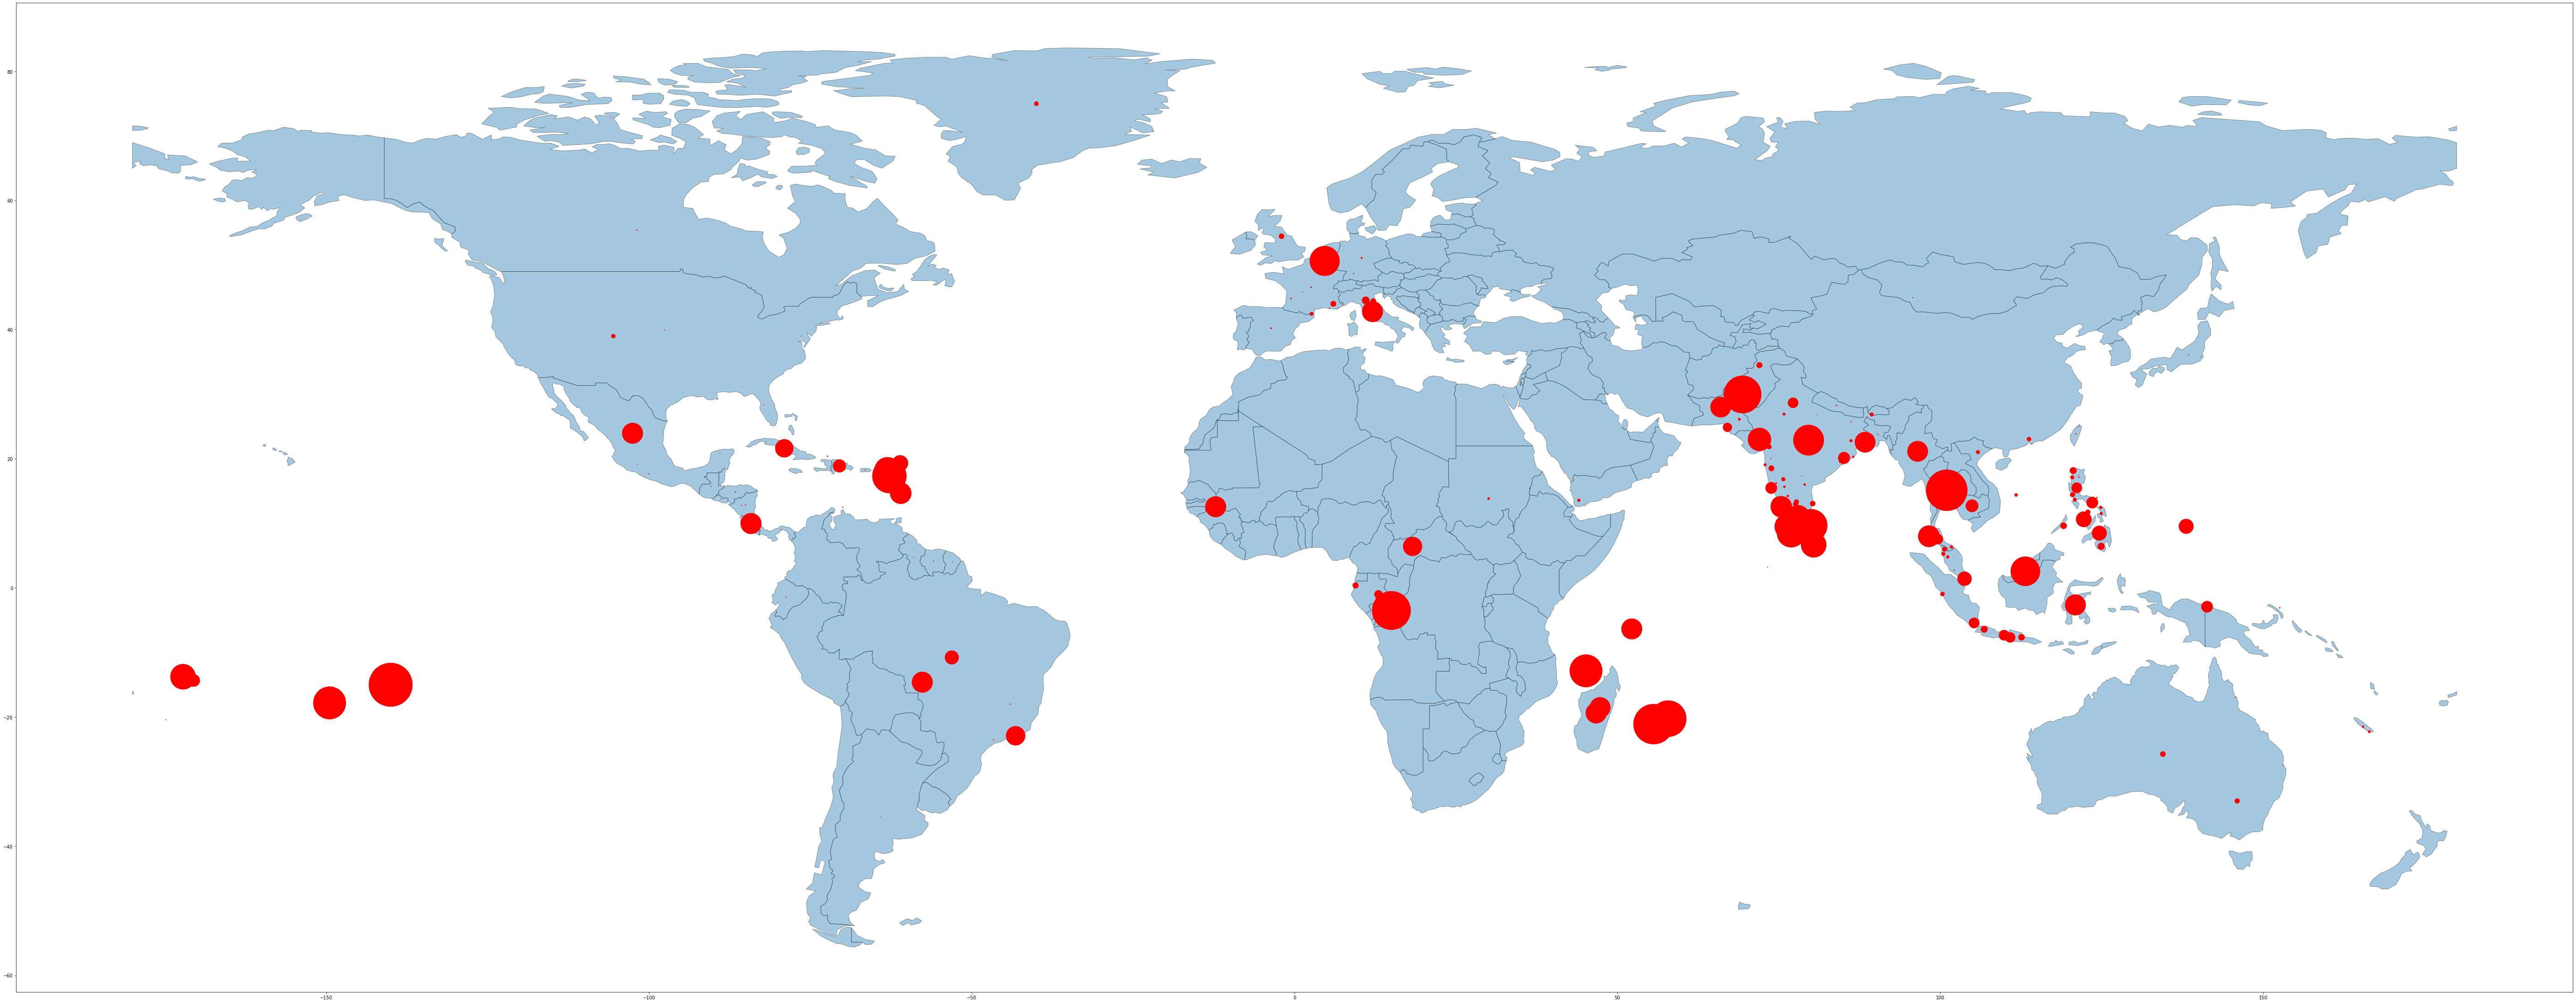

In [97]:
plot_cases('chikungunya')

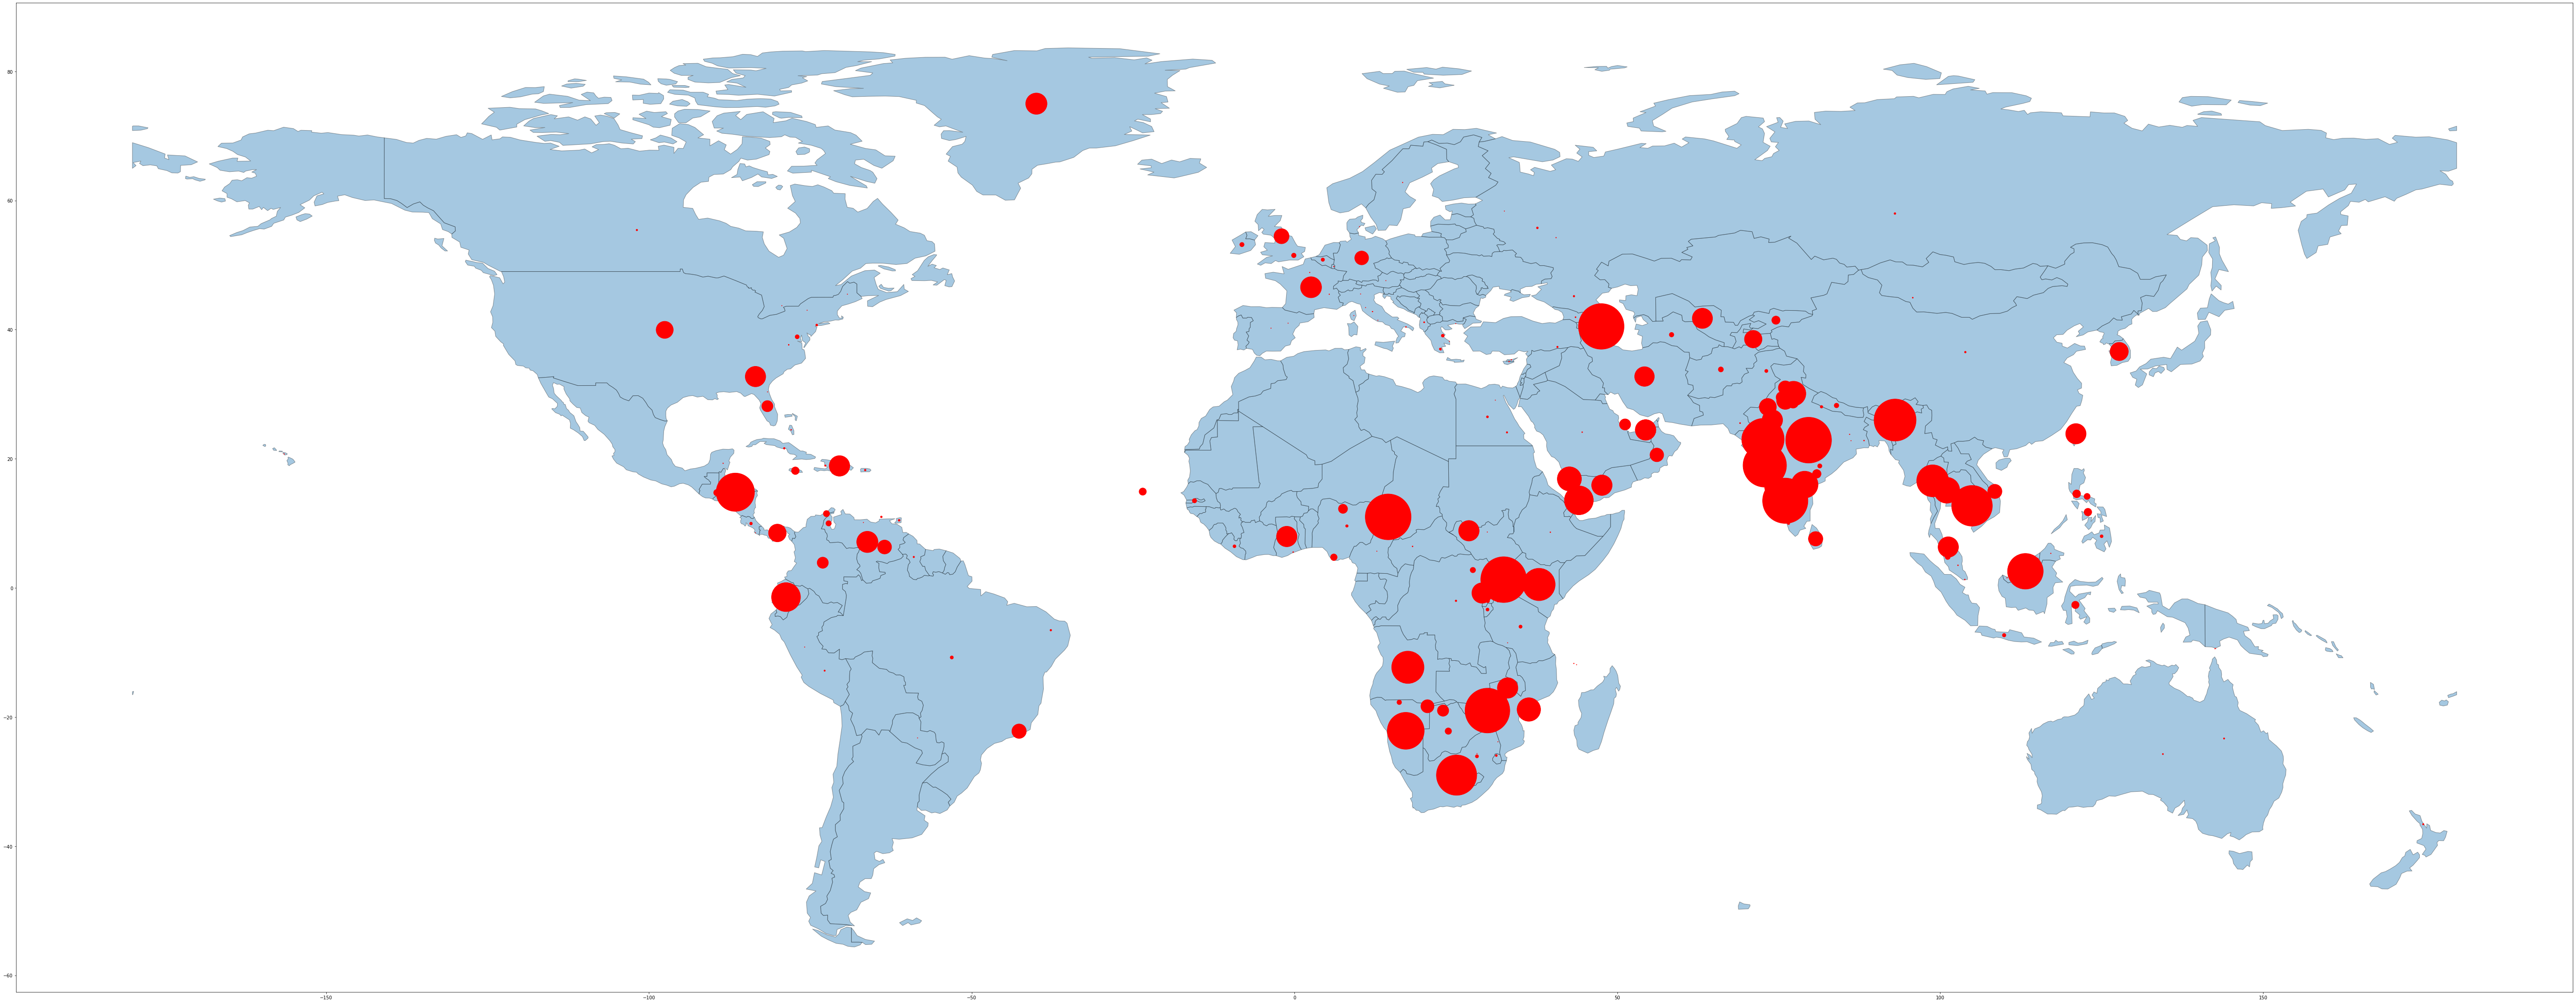

In [98]:
plot_cases('malaria')

In [166]:
df['issue_date'] = pd.to_datetime(df['issue_date'])

In [171]:
 import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Southern Hemisphere'}>

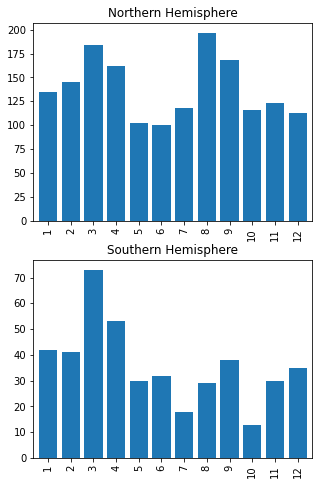

In [188]:
fig, axs = plt.subplots(2, figsize=(5,8))
axs[0].title.set_text('Northern Hemisphere')
df[df['zoom_lat']>0]['issue_date'].dt.month.value_counts(sort=False).sort_index().plot(ax=axs[0], kind='bar', width=0.8)
axs[1].title.set_text('Southern Hemisphere')
df[df['zoom_lat']<=0]['issue_date'].dt.month.value_counts(sort=False).sort_index().plot(ax=axs[1], kind='bar', width=0.8)

In [176]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [101]:
from pandas_profiling import ProfileReport

In [102]:
df.keys()

Index(['level_0', 'index', 'id', 'title', 'zoom_lat', 'zoom_lon', 'zoom_level',
       'alert_id', 'feed_id', 'summary', 'issue_date', 'load_date',
       'incident_date', 'descr', 'alert_tag_id', 'dup_count', 'dup_of',
       'unique_string', 'info_hash', 'submitted_by', 'reviewed',
       'search_string_id', 'content', 'disease', 'gpm_lat_idx', 'gpm_lon_idx',
       'precipitation_anomaly', 'location_name', 'dates_start', 'serotype',
       'total_cases', 'cases', 'severe_cases', 'deaths', 'admin1_code',
       'admin2_code', 'admin3_code', 'admin4_code', 'cases_tags',
       'deaths_tags', 'dates_end', 'precipitation_value', 'precipitation_mean',
       'issue_month'],
      dtype='object')

In [103]:
profile = ProfileReport(df.loc[:, ['zoom_lat', 'zoom_lon', 'issue_date', 'cases', 'deaths', 'precipitation_anomaly', 'dates_start']], title='eda', minimal=True)


In [104]:
profile.to_file(output_file='eda.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


# clustering

In [105]:
SEED = 69

In [106]:
from sklearn import cluster
import scipy
import seaborn as sns

In [107]:
def find_best_k(X, max_k=10, plot=True):
    X= X.dropna()
    ## iterations
    distortions = [] 
    for i in range(1, max_k+1):
        if len(X) >= i:
            model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=SEED)
            # model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(X)
            distortions.append(model.inertia_)

    ## best k: the lowest second derivative
    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

    ## plot
    if plot is True:
        fig, ax = plt.subplots()
        ax.plot(range(1, len(distortions)+1), distortions)
        # ax.axvline(k, ls='--', color="red", label="k = "+str(k))
        ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
        ax.legend()
        ax.grid(True)
        plt.show()
    return k

No handles with labels found to put in legend.


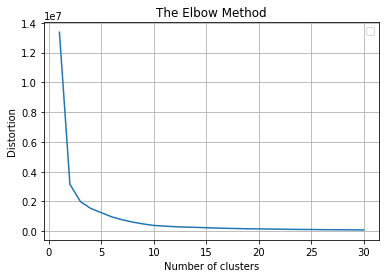

In [133]:
k = find_best_k(df[['zoom_lat', 'zoom_lon']], max_k=30, plot=True)

In [200]:
def plot_clusters(model):
    X = df[["zoom_lat", "zoom_lon"]].dropna()

    # clustering
    dtf_X = X.copy()
    dtf_X["cluster"] = model.fit_predict(X)
    k = dtf_X["cluster"].nunique()
    print("--- found", k, "clusters ---")
    print(dtf_X.groupby("cluster")["cluster"].count().sort_values(ascending=False))

    # find real centroids
    # closest, distances = scipy.cluster.vq.vq(
    #     model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
    # dtf_X["centroids"] = 0
    # for i in closest:
    #     dtf_X.iloc[i]["centroids"] = 1

    # plot
    if X.shape[1] == 2:
        lst_2Dplot = X.columns.tolist()
        th_centroids = model.cluster_centers_ if "KMeans" in str(model) else None
        # fig, ax = plt.subplots(figsize=(10,5))
        world = geopandas.read_file(
            geopandas.datasets.get_path('naturalearth_lowres'))
        ax = world[world.name != "Antarctica"].plot(
            alpha=0.4, edgecolor='black', figsize=(10, 5))
        dtf_X["cluster"] += 1
        k = dtf_X["cluster"].nunique()
        sns.scatterplot(x=lst_2Dplot[1], y=lst_2Dplot[0], data=dtf_X, palette=sns.color_palette("bright", k),
                        hue='cluster',
                        legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
        # ax.scatter(th_centroids[:, dtf_X.columns.tolist().index(lst_2Dplot[1])],
        #         th_centroids[:, dtf_X.columns.tolist().index(lst_2Dplot[0])],
        #         s=50, c='black', marker="x")

        ax.grid(True)
        plt.show()

--- found 6 clusters ---
cluster
1    709
3    448
5    300
0    244
2    220
4    176
Name: cluster, dtype: int64


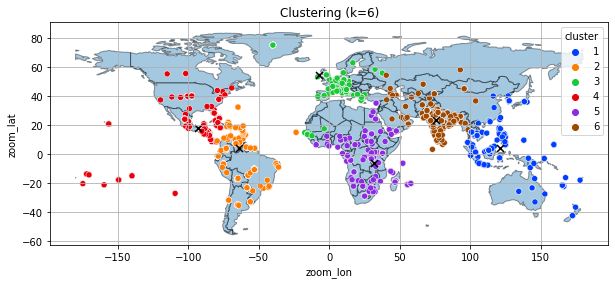

In [140]:
plot_clusters(model = cluster.KMeans(n_clusters=6, init='k-means++', random_state=SEED))

--- found 4 clusters ---
cluster
0    1187
1     559
2     316
3      35
Name: cluster, dtype: int64


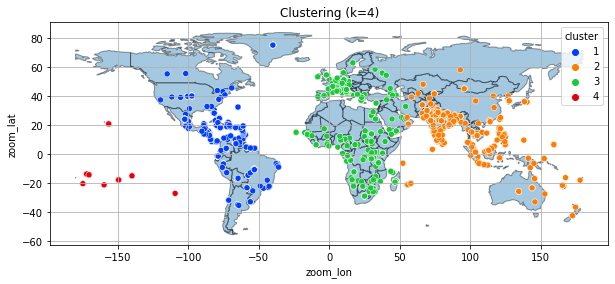

In [190]:
plot_clusters(model = cluster.MeanShift())

--- found 42 clusters ---
cluster
 1     673
 2     385
 4     155
 9      61
 13     60
 3      58
-1      53
 21     46
 14     43
 6      42
 18     39
 8      34
 7      33
 5      32
 28     31
 15     27
 10     26
 0      24
 17     18
 23     17
 26     16
 25     16
 36     16
 29     15
 24     14
 20     14
 12     14
 27     13
 16     12
 30     12
 33     12
 22     10
 34     10
 11     10
 38     10
 39     10
 32      9
 37      7
 19      6
 35      5
 40      5
 31      4
Name: cluster, dtype: int64


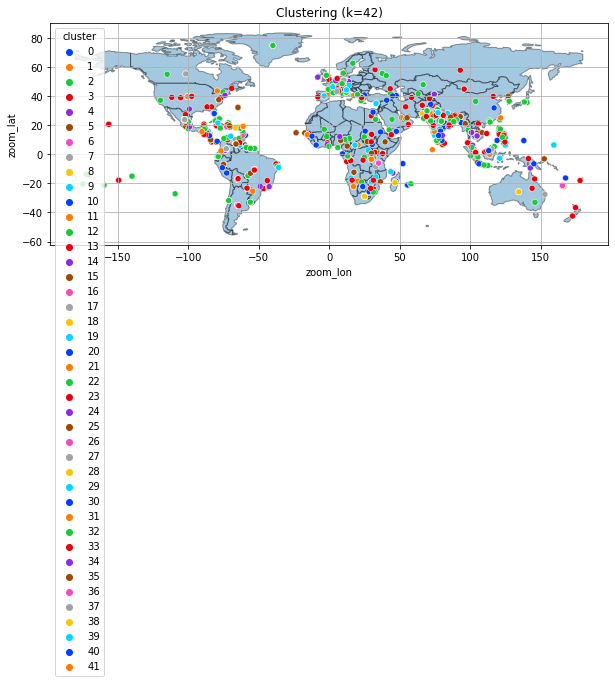

In [156]:
kms_per_radian = 6371.0088
epsilon = 1000 / kms_per_radian
plot_clusters(model = cluster.DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine'))

--- found 3 clusters ---
cluster
1    1154
0     691
2     252
Name: cluster, dtype: int64


TypeError: 'NoneType' object is not subscriptable

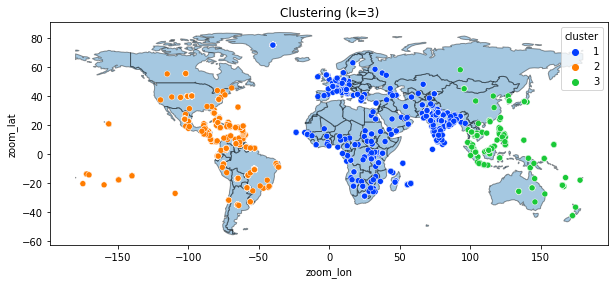

In [201]:
plot_clusters(model = cluster.Birch())

In [159]:
kmeans_model = cluster.KMeans(n_clusters=6, init='k-means++', random_state=SEED)
meanshift_model = cluster.MeanShift()
dbscan_model = cluster.DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
birch_model = cluster.Birch()

In [160]:
kmeans_model.fit(X)
meanshift_model.fit(X)
dbscan_model.fit(X)
birch_model.fit(X)

Birch()

In [161]:
kmeans_model.labels_

array([3, 3, 3, ..., 0, 0, 0])

In [162]:
birch_model.labels_

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [163]:
dbscan_model.labels_

array([ 0,  1,  1, ..., 38, 38, 38], dtype=int64)

In [164]:
from sklearn import metrics

In [165]:
print('kmeans+birch:', metrics.adjusted_rand_score(kmeans_model.labels_, birch_model.labels_))
print('kmeans+dbscan:', metrics.adjusted_rand_score(kmeans_model.labels_, dbscan_model.labels_))
print('birch+dbscan:', metrics.adjusted_rand_score(birch_model.labels_, dbscan_model.labels_))

kmeans+birch: 0.5230446515016521
kmeans+dbscan: 0.02857443607892638
birch+dbscan: 0.026464424394352207


In [33]:
from geopy.geocoders import Nominatim


In [42]:
[locator.reverse(x) for x in th_centroids]

[Location(Jharda Tahsil, Nagda, Madhya Pradesh, India, (23.59303415, 75.72100188693574, 0.0)),
 Location(Archipiélago de San Andrés, Providencia y Santa Catalina, Colombia, (12.38051665, -81.6140750764522, 0.0)),
 Location(Crosskeys ED, Ballyjamesduff Municipal District, County Cavan, Éire / Ireland, (53.9170931, -7.2434691, 0.0)),
 None,
 Location(Nova Lacerda, Microrregião de Alto Guaporé, Região Geográfica Intermediária de Cáceres, Mato Grosso, Região Centro-Oeste, Brasil, (-14.534885672428306, -59.75466509711981, 0.0)),
 Location(Mpanda, Katavi, Western Zone, 50102, Tanzania, (-6.4613, 31.51569505775718, 0.0))]

# random forest

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import numpy as np
from sklearn import metrics

In [6]:
SEED = 69

In [52]:
df.keys()

Index(['level_0', 'index', 'id', 'title', 'zoom_lat', 'zoom_lon', 'zoom_level',
       'alert_id', 'feed_id', 'summary', 'issue_date', 'load_date',
       'incident_date', 'descr', 'alert_tag_id', 'dup_count', 'dup_of',
       'unique_string', 'info_hash', 'submitted_by', 'reviewed',
       'search_string_id', 'content', 'disease', 'gpm_lat_idx', 'gpm_lon_idx',
       'precipitation_anomaly', 'location_name', 'dates_start', 'serotype',
       'total_cases', 'cases', 'severe_cases', 'deaths', 'admin1_code',
       'admin2_code', 'admin3_code', 'admin4_code', 'cases_tags',
       'deaths_tags', 'dates_end', 'precipitation_value', 'precipitation_mean',
       'issue_month'],
      dtype='object')

In [50]:
df_rf = df.loc[:, ['zoom_lat', 'zoom_lon', 'zoom_level', 'disease',
                   'precipitation_mean', 'precipitation_value', 'precipitation_anomaly', 
					'cases', 'deaths', 'issue_month', #'issue_date', 
					]]

df_rf = df_rf[df_rf['cases'] < 125000000]
df_rf = df_rf[df_rf['deaths'] < 20000]

one_hot = pd.get_dummies(df_rf['disease'])
diseases = df_rf['disease']
df_rf = df_rf.drop('disease', axis=1)
df_rf = df_rf.join(one_hot)

y = df_rf['cases']
X = df_rf.drop('cases', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=diseases)

In [42]:
# df_rf = df.loc[:, ['zoom_lat', 'zoom_lon', 'zoom_level', 'disease',
#                    'precipitation_mean', 'precipitation_value', 'precipitation_anomaly', 
# 					'cases', 'deaths', 'issue_month', #'issue_date', 
# 					]]

# df_rf['severe'] = ((df_rf['cases'] > 1000) | (df_rf['deaths'] > 100))

# one_hot = pd.get_dummies(df_rf['disease'])
# diseases = df_rf['disease']
# df_rf = df_rf.drop(['disease', 'cases', 'deaths'], axis=1)
# df_rf = df_rf.join(one_hot)

# y = df_rf['severe']
# X = df_rf.drop('severe', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=diseases)

In [40]:
def run_model(model, param_grid, **kwargs):
    grid = GridSearchCV(model, param_grid, **kwargs)
    grid.fit(X_train, y_train)
    return grid

In [46]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': list(range(100, 500, 100)),  
              'min_samples_split': [2, 3, 4],
              'max_features': ['auto', 'sqrt', 'log2', *list(range(1,4))]}

rf = run_model(RandomForestClassifier(random_state=SEED), param_grid, verbose=3, n_jobs=-1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [47]:
metrics.accuracy_score(y_test, rf.predict(X_test))

0.8004750593824228

In [48]:
metrics.balanced_accuracy_score(y_test, rf.predict(X_test))

0.5893732492997199

In [49]:
rf.best_estimator_.feature_importances_

array([0.1765417 , 0.14971192, 0.03134238, 0.14442074, 0.16647738,
       0.17214021, 0.11564159, 0.00837531, 0.01058923, 0.01545136,
       0.00930819])

In [51]:
from sklearn import linear_model

# param_grid = {'alpha': np.logspace(-4, -0.5, 30), 'tol': np.logspace(1e-4, 1e-2, 30)}

# rf = run_model(Lasso(random_state=SEED, max_iter=10000), param_grid, verbose=3, n_jobs=-1)

pipe = make_pipeline(preprocessing.StandardScaler(), linear_model.Lasso(max_iter=10000))
pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(max_iter=10000))])

In [52]:
pipe.score(X_test, y_test)

0.005319182097378472

In [55]:
from sklearn import ensemble

# param_grid = {'alpha': np.logspace(-4, -0.5, 30), 'tol': np.logspace(1e-4, 1e-2, 30)}

# rf = run_model(Lasso(random_state=SEED, max_iter=10000), param_grid, verbose=3, n_jobs=-1)

pipe = make_pipeline(preprocessing.StandardScaler(), ensemble.RandomForestRegressor())
pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [57]:
pipe.score(X_test, y_test)

-0.03423245010003906

In [56]:
metrics.mean_squared_error(y_test, pipe.predict(X_test))

2322589060525.1025

In [121]:
len(df)

2103

In [124]:
df['issue_date'].max()

Timestamp('2021-07-20 14:42:19')

In [128]:
len(df[df['disease'] == 'chikungunya'])

531

In [133]:
df.keys()

Index(['index', 'id', 'title', 'zoom_lat', 'zoom_lon', 'zoom_level',
       'alert_id', 'feed_id', 'summary', 'issue_date', 'load_date',
       'incident_date', 'descr', 'alert_tag_id', 'dup_count', 'dup_of',
       'unique_string', 'info_hash', 'submitted_by', 'reviewed',
       'search_string_id', 'content', 'disease', 'gpm_lat_idx', 'gpm_lon_idx',
       'precipitation_anomaly', 'location_name', 'dates_start', 'serotype',
       'total_cases', 'cases', 'severe_cases', 'deaths', 'admin1_code',
       'admin2_code', 'admin3_code', 'admin4_code', 'cases_tags',
       'deaths_tags', 'dates_end', 'precipitation_value', 'precipitation_mean',
       'issue_month'],
      dtype='object')

In [130]:
df['zoom_lat'].nunique()

518

In [131]:
df['zoom_lon'].nunique()

523

# e

In [2]:
import pickle

In [3]:
with open('gpm.pickle', 'rb') as handle:
	bruh = pickle.load(handle)

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [36]:
plot_df = df[df['cases'] <= 10000]
plot_df.loc[:, 'cases'] = plot_df['cases']/10
gdf = geopandas.GeoDataFrame(plot_df, geometry=geopandas.points_from_xy(plot_df['zoom_lon'], plot_df['zoom_lat']))

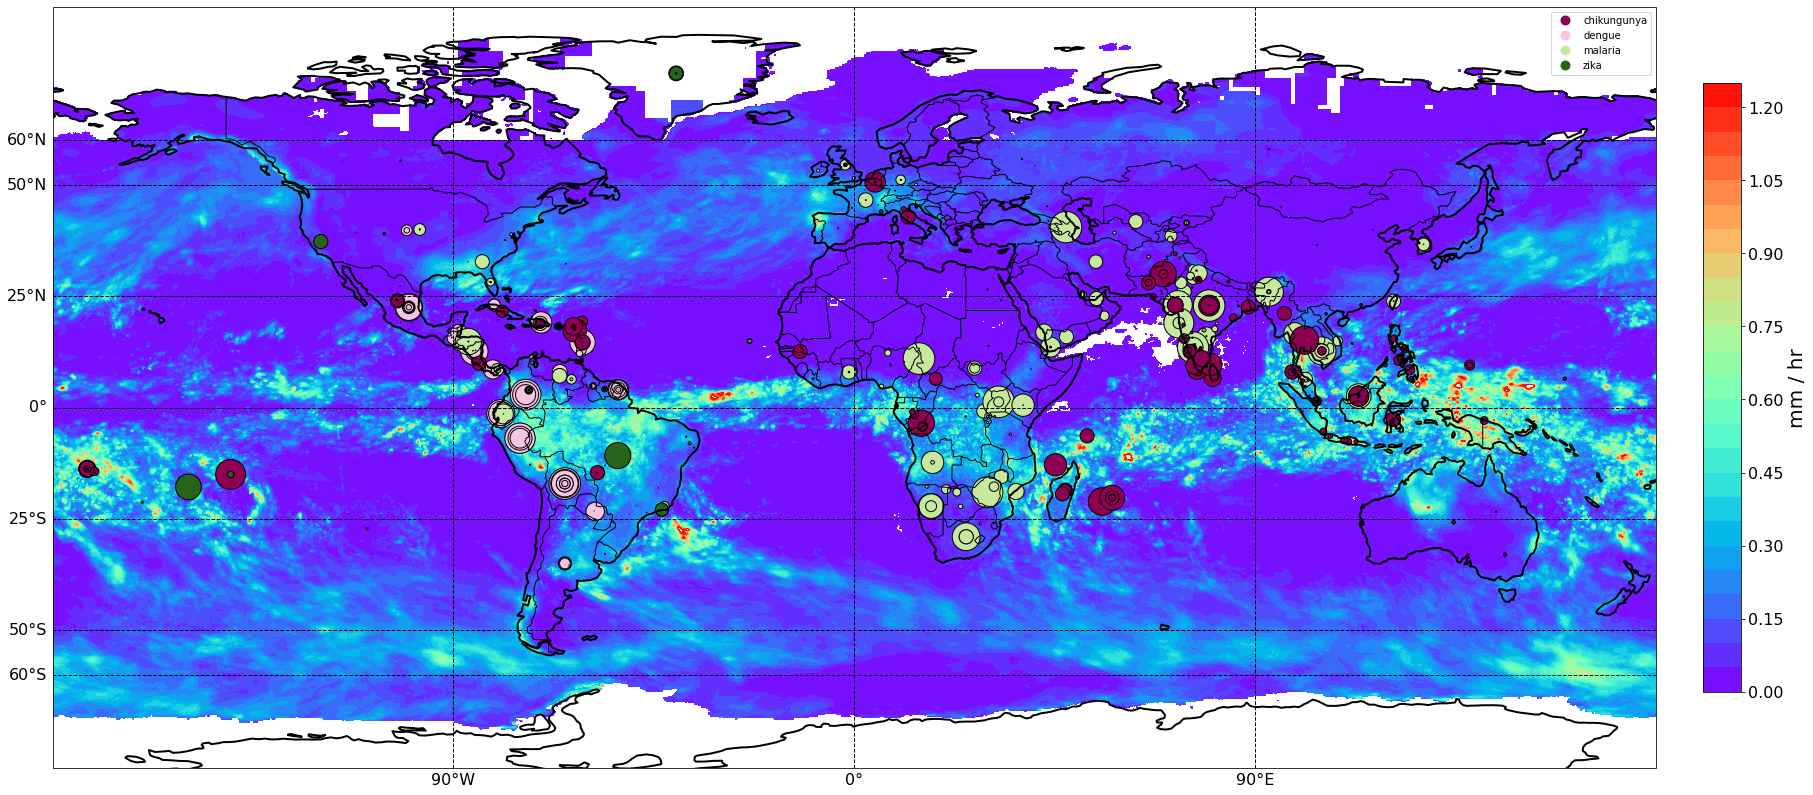

In [49]:


import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

precip = bruh['precip'][0][:][:]
precip = np.transpose(precip)
theLats = bruh['lat']
theLons = bruh['lon']
x, y = np.float32(np.meshgrid(theLons, theLats))
 

# Plot the data using matplotlib and cartopy

# Set the figure size, projection, and extent
fig = plt.figure(figsize=(42,14))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-180,180,-60,60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m",linewidth=2)
ax.add_feature(cartopy.feature.BORDERS)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,1.26,0.05)
plt.contourf(x, y, precip, clevs, cmap=plt.cm.rainbow)
# plt.title('IMERG Mean Precipitation and Outbreaks (total dataset)', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm / hr',size=20)
cb.ax.tick_params(labelsize=16)
gdf.plot(ax=ax, column='disease', markersize='cases', edgecolors='k', cmap='PiYG', legend=True)
# Save the figure as a PNG:

fig.savefig('GPM_3IMERGP_plot.png', bbox_inches='tight', pad_inches = 0.1)

In [189]:
df['zoom_lat'].between(-20, 20).sum()

1315

In [190]:
1315/len(df)

0.6252971944840704

In [191]:
report = ProfileReport(df.loc[:, ['zoom_lat', 'zoom_lon', 'zoom_level', 'disease',
                   'precipitation_mean', 'precipitation_value', 'precipitation_anomaly', 
					'cases', 'deaths', 'issue_month', #'issue_date', 
					]], title='eda')

In [25]:
df[df['deaths'] > 10000]['deaths']

793        100000.0
844        400000.0
877         15000.0
911         50000.0
943        584000.0
955        200000.0
959        600000.0
962         20000.0
983        650000.0
993       1000000.0
1001      1000000.0
1023       655000.0
1055       985000.0
1069    200000000.0
1071      1000000.0
1105       863000.0
1108        40000.0
1114       200000.0
1117      1000000.0
1121      1000000.0
1123       300000.0
1185      1000000.0
1243      4200000.0
1252      3000000.0
1360      1000000.0
1516        35000.0
1768        20000.0
Name: deaths, dtype: float64

In [28]:
df.iloc[983]['content']

'Drug resistant malaria on the rise along the Thai-Myanmar border\n--------------------------------------------------\nThe number of artemisinin/mafloquine-resistant cases is on the rise along the Thai-Myanmar border, according to Kanchanaburi health workers.\nA girl, age 6, bravely held out her forefinger for a quick jab at the Malaria Post in Tai Muang, 10 kilometres [6.2 miles] from the Myanmar border, in Thailand\'s Kanchanaburi province.\nA month ago, a girl, whose family is from Myanmar\'s Karen ethnic minority group and lacks Thai citizenship, tested positive for malaria. She was back for a follow-up test after a combined treatment of the anti-malarial drugs artemisinin and mefloquine. "She has tested negative," Malaria Post worker Laksanna Kaewlere said, after checking her blood sample in a test kit. Had she tested positive, she would have joined the growing ranks of patients for whom the most recent drug against the malaria parasite -- artemisinin -- has failed. \nArtemisinin 

In [44]:
df.loc[:, ['zoom_lat', 'zoom_lon', 'zoom_level', 'disease',
                   'precipitation_mean', 'precipitation_value', 'precipitation_anomaly', 
					'cases', 'deaths', 'issue_date', #'issue_date', 
					]].sample(4).to_latex()

zoom_lat   zoom_lon  zoom_level  disease  precipitation_mean  \
165   17.250512 -62.672597           4   dengue            0.113894   
1211 -28.998529  25.092541           5  malaria            0.055059   
160    4.841710 -58.641689           4   dengue            0.259926   
916  -15.500000  33.000000           4  malaria            0.100706   

      precipitation_value  precipitation_anomaly   cases  deaths  \
165              0.114341               0.003922     2.0     0.0   
1211             0.172326               2.129865   473.0     1.0   
160              0.283576               0.090987   403.0     0.0   
916              0.227368               1.257742  2015.0   213.0   

              issue_date  
165  2020-11-15 19:55:03  
1211 2006-01-24 23:50:00  
160  2020-11-15 19:55:03  
916  2016-01-11 14:29:21

In [50]:
print(df.iloc[[165,1211,160,916]][['zoom_lat', 'zoom_lon', 'zoom_level', 'disease',
                   'precipitation_mean', 'precipitation_value', 'precipitation_anomaly', 
					'cases', 'deaths', 'issue_date', #'issue_date', 
					]].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrlrrrrrl}
\toprule
{} &  zoom\_lat &  zoom\_lon &  zoom\_level &  disease &  precipitation\_mean &  precipitation\_value &  precipitation\_anomaly &    cases &  deaths &          issue\_date \\
\midrule
165  &    17.251 &   -62.673 &           4 &   dengue &               0.114 &                0.114 &                  0.004 &    2.000 &   0.000 & 2020-11-15 19:55:03 \\
1211 &   -28.999 &    25.093 &           5 &  malaria &               0.055 &                0.172 &                  2.130 &  473.000 &   1.000 & 2006-01-24 23:50:00 \\
160  &     4.842 &   -58.642 &           4 &   dengue &               0.260 &                0.284 &                  0.091 &  403.000 &   0.000 & 2020-11-15 19:55:03 \\
916  &   -15.500 &    33.000 &           4 &  malaria &               0.101 &                0.227 &                  1.258 & 2015.000 & 213.000 & 2016-01-11 14:29:21 \\
\bottomrule
\end{tabular}



In [53]:
df[df['deaths'] < 20000]['deaths'].mean()

50.16177178623014

In [56]:
from scipy import stats

In [61]:
stats.pearsonr(df['cases'].fillna(0), df['precipitation_anomaly'])

(0.03578995830143909, 0.1001071669601592)

In [71]:
stats.pearsonr(df['deaths'].fillna(0), df['precipitation_anomaly'])

(-0.024494371372013872, 0.260513616735926)

# u

TypeError: Length of x (2103) must match number of columns in z (3)

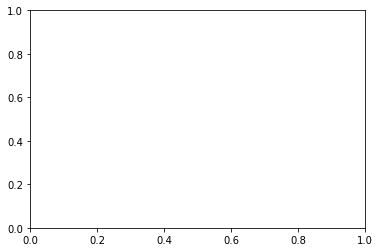

In [105]:
plt.contourf(df['zoom_lon'], df['zoom_lat'], , clevs, cmap=plt.cm.rainbow)

In [113]:
np.array(df[['zoom_lat', 'zoom_lon', 'precipitation_anomaly']])

array([[ 3.97837304e+01, -1.00445882e+02, -7.58004034e-01],
       [ 1.68259793e+01, -8.87600927e+01, -5.29655253e-01],
       [ 1.02735633e+01, -8.40739102e+01, -6.29654952e-01],
       ...,
       [ 6.49238000e+00,  1.59404221e+02,  6.89409367e-02],
       [ 6.49238000e+00,  1.59404221e+02,  6.89409367e-02],
       [ 6.49238000e+00,  1.59404221e+02,  1.74912270e-01]])

In [114]:
np.meshgrid(df['zoom_lat'], df['zoom_lon'])

In [62]:
pp = df['precipitation_anomaly'].sort_values()

In [65]:
pp[:5].index

Int64Index([1177, 954, 955, 953, 1046], dtype='int64')

In [64]:
pp[-5:]

1098    4.112732
1099    4.112732
1441    4.245567
1717    4.303051
1701    4.514703
Name: precipitation_anomaly, dtype: float64

In [71]:
least_anom = np.array(df.iloc[pp[:5].index][['zoom_lat', 'zoom_lon']])
most_anom = np.array(df.iloc[pp[-5:].index][['zoom_lat', 'zoom_lon']])

In [79]:
least_anom

array([[-12.29529 ,  17.54468 ],
       [ 26.494249,  29.87196 ],
       [ 24.0875  ,  32.898891],
       [ 26.494249,  29.87196 ],
       [ 29.076321,  31.09693 ]])

In [70]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='bruh')
[locator.reverse(x) for x in least_anom]

[Location(Bié, Angola, (-12.2630485, 17.4967812, 0.0)),
 Location(الوادي الجديد, مصر, (24.8766665, 28.775734531760392, 0.0)),
 Location(شارع الشواربى الجديد, نجم الدين, أسوان, 81511, مصر, (24.087717049088504, 32.89889315433337, 0.0)),
 Location(الوادي الجديد, مصر, (24.8766665, 28.775734531760392, 0.0)),
 Location(ميدان المديرية, كوبرى مديريه بنى سويف, المولد النبوى, محافظة بنى سويف, 62513, مصر, (29.0755873, 31.097133350454193, 0.0))]

In [72]:
[locator.reverse(x) for x in most_anom]

[Location(Red Cross Street, Byculla West, E Ward, Zone 1, Mumbai, Mumbai City, Maharashtra, 400027, India, (18.974936815919055, 72.8257788482702, 0.0)),
 Location(Red Cross Street, Byculla West, E Ward, Zone 1, Mumbai, Mumbai City, Maharashtra, 400027, India, (18.974936815919055, 72.8257788482702, 0.0)),
 Location(12R, PECHS Block 2, Pakistan Employee Co-operative Housing Society, کراچی, سندھ, 75100, پاکستان, (24.8667243, 67.05004305528857, 0.0)),
 Location(Kamla Nehru Ridge, Civil Lines Tehsil, Central Delhi, Delhi, 110007, India, (28.672002, 77.2110417, 0.0)),
 Location(Loreto Convent Quatre Bornes, Labourdonnais Avenue, Quatre Bornes, Plaines Wilhems, 72444, Mauritius, (-20.2640378, 57.47357265, 0.0))]

In [80]:
df.iloc[pp[:5].index].iloc[4]

level_0                                                               1049
index                                                                 1049
id                                                                  801120
title                                ['Malaria - Egypt: (BN) unconfirmed']
zoom_lat                                                         29.076321
zoom_lon                                                          31.09693
zoom_level                                                               4
alert_id                                                            801120
feed_id                                                                  1
summary                        PRO/EDR> Malaria - Egypt: (BN) unconfirmed 
issue_date                                             2011-07-28 21:48:43
load_date                                              2011-07-28 22:00:09
incident_date                                                          NaN
descr                    